# Loading Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import makedirs
from os import listdir 
from matplotlib.image import imread
import PIL
import tensorflow as tf
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

print(tf.__version__)


2.15.0


# Data Extraction

In [114]:
files = 'PetImages.zip'
photo = 'photo/'

In [115]:
# Check if the file exists
if os.path.exists(files):
    # Get the file size
    file_size = os.path.getsize(files)
    print(f"File Size: {file_size} bytes")
    
    # Check the file type
    file_type = os.path.splitext(files)[1]
    print(f"File Type: {file_type}")
else:
    # If the file does not exist, print an error message
    print("File does not exist.")

File Size: 824863963 bytes
File Type: .zip


In [6]:
import zipfile

try:
    # Open the zip file in read mode
    with zipfile.ZipFile(files, 'r') as zipp:
        # Extract all contents of the zip file to the specified directory
        zipp.extractall(photo)
    # Print a success message if extraction is successful
    print("Extraction successful.")
except zipfile.BadZipFile:
    # Handle the error if the file is not a valid zip file or it is corrupted
    print("Error: The file is not a valid zip file or it is corrupted.")

Extraction successful.


In [5]:
# Define your dataset folder path
dataset_path = 'photo/PetImages'

In [6]:
# Function to check if an image file is valid
from PIL import Image
def is_valid_image(file_path):
    try:
        # Open and check if the image can be loaded
        Image.open(file_path)
        return True
    except (IOError, SyntaxError):
        # Invalid image file
        return False

In [7]:
# Initialize empty lists to store file paths and labels
file_paths = []
labels = []

# Loop through each label (Cat and Dog) to filter out valid images
for label in ['Cat', 'Dog']:
    # Construct the path to the label's folder
    label_folder = os.path.join(dataset_path, label)
    
    # Loop through each file in the label's folder
    for file_name in os.listdir(label_folder):
        # Construct the full file path
        file_path = os.path.join(label_folder, file_name)
        
        # Check if the file is a valid image
        if is_valid_image(file_path):
            # If valid, append the file path to the file_paths list
            file_paths.append(file_path)
            
            # Append the corresponding label (as a string) to the labels list
            labels.append('Cat' if label == 'Cat' else 'Dog')

# Convert lists to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)

C:\Users\kasid\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


# split dataset 

In [91]:
# Split the data into training and testing+validation sets
X_train, X, y_train, y  = train_test_split(
    file_paths, labels, test_size=0.4, random_state=99, stratify=labels)

In [92]:
# Split the data into validation and testing sets
X_test, X_validation, y_test, y_validation = train_test_split(
    X, y, test_size=0.5, random_state=99, stratify=y)

# Data Generator

In [93]:
train_gen = ImageDataGenerator(rescale=1./255)
train_generator = train_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=(32,32),  # adjust target_size as needed
    batch_size=64,
    class_mode='categorical',  # binary classification
    shuffle=True)

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_test, 'class': y_test}),
    x_col='filename',
    y_col='class',
    target_size=(32,32),  # adjust target_size as needed
    batch_size=64,
    class_mode='categorical',  # binary classification
    shuffle=False)

val_gen = ImageDataGenerator(rescale=1./255)
val_generator = val_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_validation, 'class': y_validation}),
    x_col='filename',
    y_col='class',
    target_size=(32,32),  # adjust target_size as needed
    batch_size=64,
    class_mode='categorical',  # binary classification
    shuffle=False)

Found 14998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [94]:
for batch in test_generator:
    # Extract the first image and label from the batch
    image = batch[0][0]  # First image in the batch
    label = batch[1][0]  # Corresponding label

    # Print the label (0 for Cat, 1 for Dog)
    print(label)
    
    break

[1. 0.]


In [95]:
class_indices = test_generator.class_indices

# Invert the dictionary to map indices to class names
class_names_mapping = {v: k for k, v in class_indices.items()}

# Check which class is mapped to class 0 and which to class 1
class_0 = class_names_mapping[0]
class_1 = class_names_mapping[1]

print(f"Class 0 is mapped to '{class_0}'")
print(f"Class 1 is mapped to '{class_1}'")

Class 0 is mapped to 'Cat'
Class 1 is mapped to 'Dog'


# Deep Learning Model

In [96]:
# callbacks
model_checkpoint_cb1 = ModelCheckpoint('model_scratch/woaugment', monitor='val_loss',save_best_only=True, save_weights_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)
early_stoping = EarlyStopping(monitor='val_loss',patience= 5,restore_best_weights=True,verbose=0)

In [99]:
# training from scratch
def build_model_scratch1():
    model = Sequential()
  # change the input shape here
    model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
  # change this to binary label
    model.add(Dense(2, activation='softmax'))

    return model
#model.summary()

# Fit the model

In [100]:
# train without data augmentation
model = build_model_scratch1()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1,
                    callbacks=[model_checkpoint_cb1,learning_rate_reduction])

Epoch 1/20
 55/235 [======>.......................] - ETA: 25s - loss: 1.0080 - accuracy: 0.5688

C:\Users\kasid\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


235/235 [==============================] - 45s 184ms/step - loss: 0.7692 - accuracy: 0.6229 - val_loss: 0.6869 - val_accuracy: 0.5290 - lr: 0.0010
Epoch 2/20
235/235 [==============================] - 37s 159ms/step - loss: 0.5926 - accuracy: 0.6882 - val_loss: 0.6891 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 3/20
235/235 [==============================] - 38s 160ms/step - loss: 0.5397 - accuracy: 0.7242 - val_loss: 0.5128 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 4/20
235/235 [==============================] - 37s 159ms/step - loss: 0.5014 - accuracy: 0.7546 - val_loss: 0.6925 - val_accuracy: 0.6470 - lr: 0.0010
Epoch 5/20
235/235 [==============================] - 37s 159ms/step - loss: 0.4732 - accuracy: 0.7688 - val_loss: 0.4923 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 6/20
235/235 [==============================] - 37s 159ms/step - loss: 0.4605 - accuracy: 0.7786 - val_loss: 0.4641 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 7/20
235/235 [==============================] - 46s 198ms

# Plot learning curves

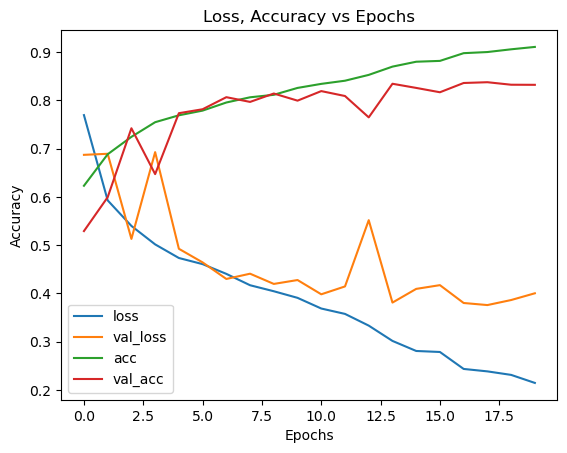

In [101]:
#plot the learning curves
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.title('Loss, Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Evaluvation

In [102]:
# test set
loss, acc = model.evaluate(test_generator)
print('test_oss:', loss)
print('test_acc:', acc)

79/79 [==============================] - 11s 136ms/step - loss: 0.4159 - accuracy: 0.8328
test_oss: 0.4158506393432617
test_acc: 0.8327999711036682


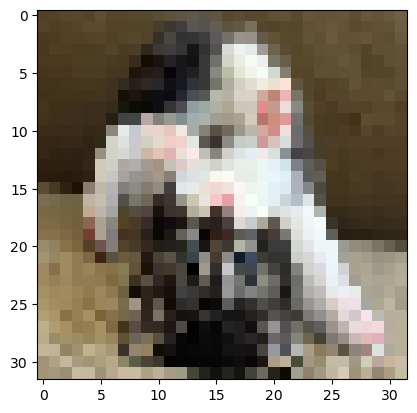

1/1 [==============================] - 0s 20ms/step
Predictions: [[1. 0.]]
Predicted class: cat


In [106]:
img_path = 'cat1.jpg'  # Path to your image
img = keras.utils.load_img(img_path, target_size=(32, 32))  # Adjust target_size to match your model input size
img_array = keras.utils.img_to_array(img)

# Display the image
plt.imshow(img_array / 255)
plt.show()

# Reshape the image for the model
img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))

# Preprocess the image (BGR and zero-centered)
img_array = keras.applications.resnet.preprocess_input(img_array)

# Predict using the model
predictions = model.predict(img_array)

# Output the predictions
print("Predictions:", predictions)

# Convert predictions to class labels
class_labels = ['cat', 'dog']  # Adjust this list based on your model's class order
predicted_class = class_labels[np.argmax(predictions)]
print("Predicted class:", predicted_class)

In [107]:
result = model.predict(test_generator,batch_size = 64,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

In [110]:
cm = confusion_matrix(y_true,y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['cat','dog'], 
                     columns = ['cat','dog'])

C:\Users\kasid\AppData\Local\Temp\ipykernel_27088\2291354439.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cm_percentage = cm_df / cm_df.sum(axis=1)[:, np.newaxis] * 100


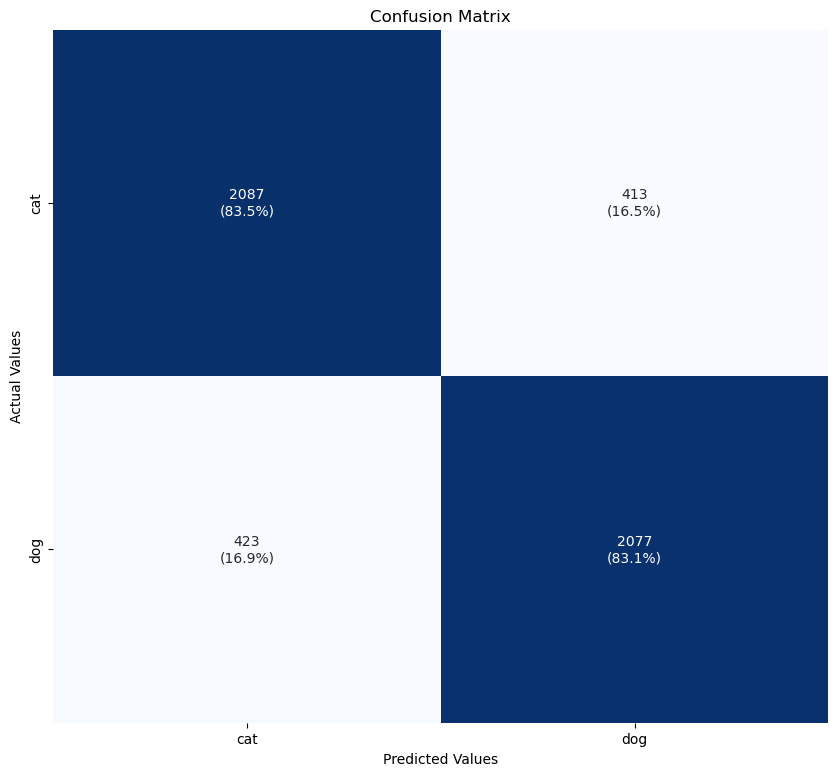

In [113]:
import seaborn as sns
# Calculate the percentage annotations
cm_percentage = cm_df / cm_df.sum(axis=1)[:, np.newaxis] * 100

# Create a custom annotation format function
def annot_format(value, percentage):
    return f'{int(value)}\n({percentage:.1f}%)'

# Create the annotations with integer values and percentages
annot = np.array([[annot_format(cm_df.iloc[i, j], cm_percentage.iloc[i, j]) for j in range(cm_df.shape[1])] for i in range(cm_df.shape[0])])

plt.figure(figsize=(10, 9))
sns.heatmap(cm_df, annot=annot, fmt='', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()